In [304]:
# Import Libraries 
import cv2
import numpy as np
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt

def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)



In [305]:
class options:
    def __init__(self):
        self.image = "/Users/garethtate/plantcv/TestImagesRPi/Still-1-RGB-2021-07-02_13-02-08.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "watershed_test_results.json"
        self.outdir = "/Users/garethtate/plantcv" # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

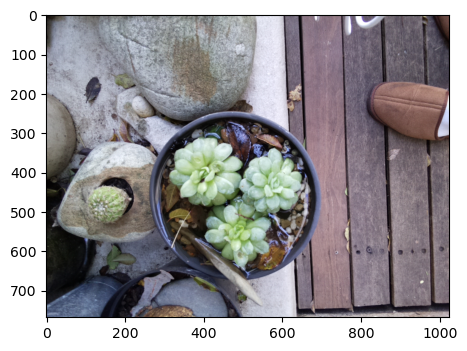

In [306]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

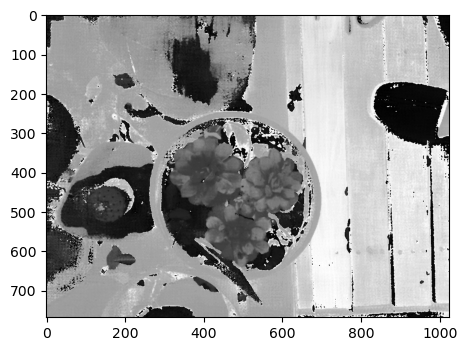

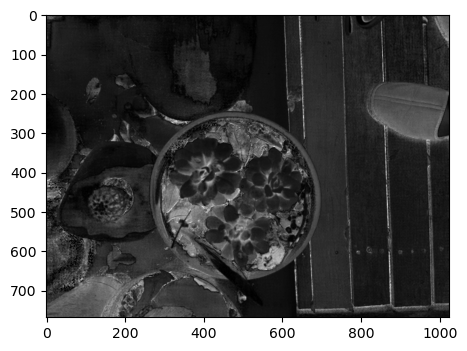

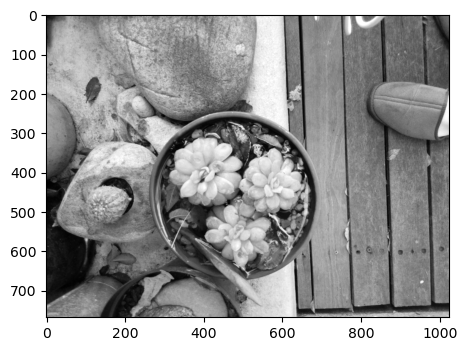

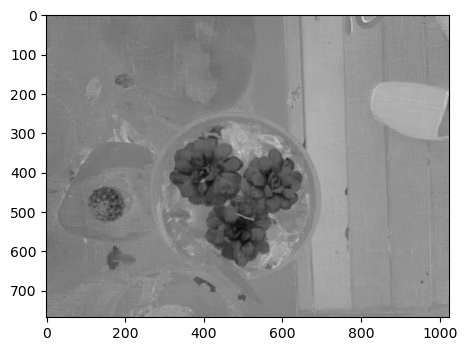

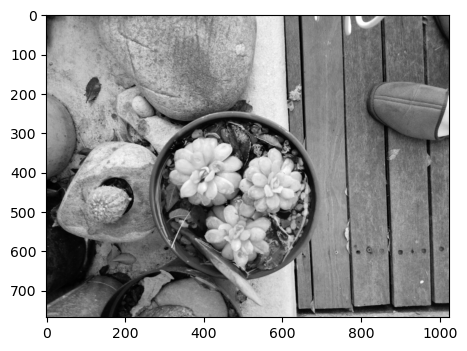

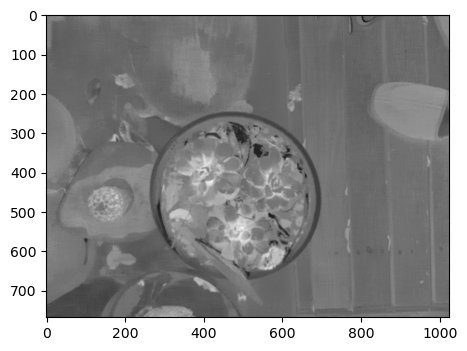

In [307]:
# image converted from RGB to HSV, channels are then split. 
# Hue ('h') channel is output
h_channel = pcv.rgb2gray_hsv(rgb_img=img, channel='h')
s_channel = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
v_channel = pcv.rgb2gray_hsv(rgb_img=img, channel='v')

a_channel = pcv.rgb2gray_lab(rgb_img=img, channel='a')
l_channel = pcv.rgb2gray_lab(rgb_img=img, channel='l')
b_channel = pcv.rgb2gray_lab(rgb_img=img, channel='b')

In [308]:
# Create binary image from a gray image based on threshold values, 
# targeting light objects in the image.
#threshold_light = pcv.threshold.binary(gray_img=h_channel, threshold=80, max_value=255, object_type='dark')

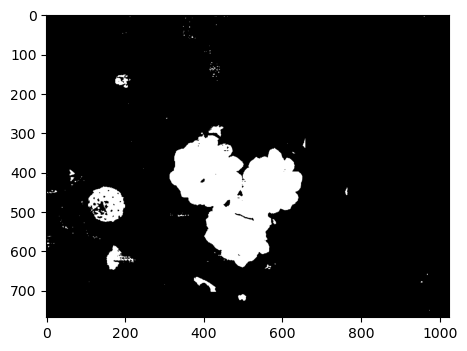

In [309]:
#mask, masked_img = pcv.threshold.custom_range(img=a_channel, lower_thresh=[0], upper_thresh=[255], channel='grey')

# Create binary image from a gray image based
#threshold_gaussian = pcv.threshold.gaussian(gray_img=a_channel, max_value=255, object_type='dark')

# Create binary image from a gray image based 
#threshold_mean = pcv.threshold.mean(gray_img=a_channel, max_value=255, object_type='dark')

# Create binary image from a gray image based on threshold values. 
# Targeting light objects in the image.
threshold_light = pcv.threshold.otsu(gray_img=a_channel, max_value=255, object_type='dark')

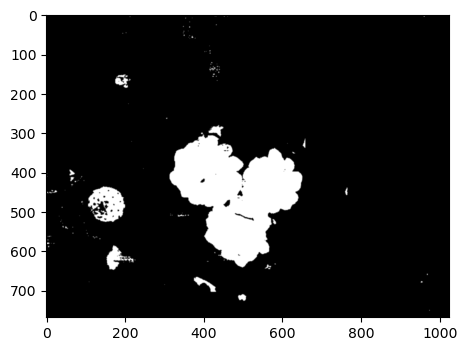

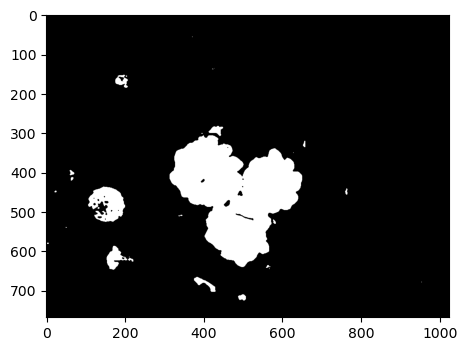

In [310]:
# Apply gaussian blur to a binary image that has been previously thresholded.
gaussian_img = pcv.gaussian_blur(img=threshold_light, ksize=(3, 3), sigma_x=0, sigma_y=None)



binary_img = pcv.median_blur(gray_img=threshold_light, ksize=5)

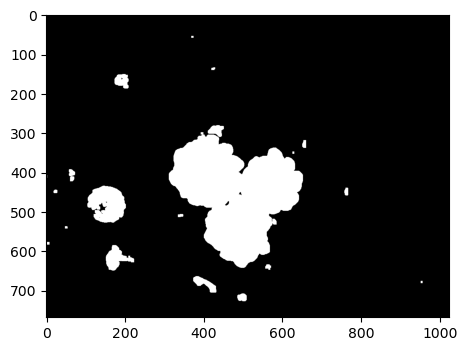

In [311]:
# Perform dilation
# Results in addition of pixels to the boundary of object
dilate_img = pcv.dilate(gray_img=binary_img, ksize=3, i=2)

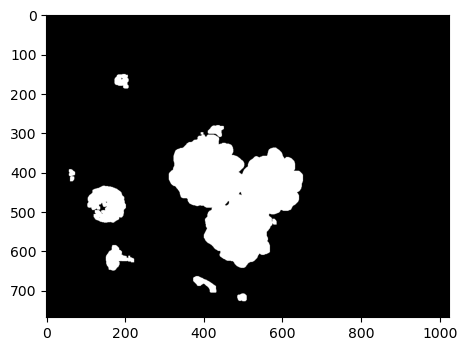

In [312]:
# Apply fill to a binary image that has had a median blur applied.
# Image mask is the same binary image with median blur.

fill_image = pcv.fill(bin_img=dilate_img, size=300)

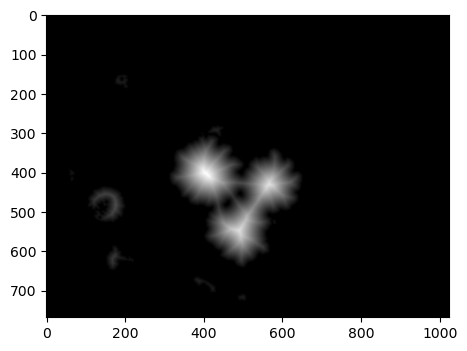

In [313]:
# Results in addition of pixels to the boundary of object
distance_transform_img = pcv.distance_transform(bin_img=fill_image, distance_type=2, mask_size=5)


In [314]:
# Finding sure foreground area
ret, sure_fg = cv2.threshold(distance_transform_img,0.7*distance_transform_img.max(),255,0)

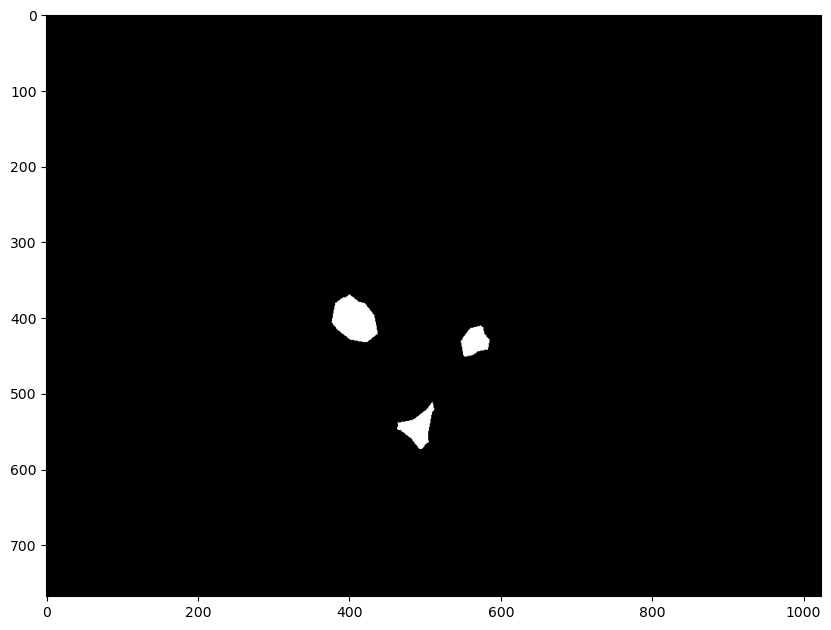

In [315]:
display(sure_fg,cmap='gray')

In [316]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(fill_image,sure_fg)

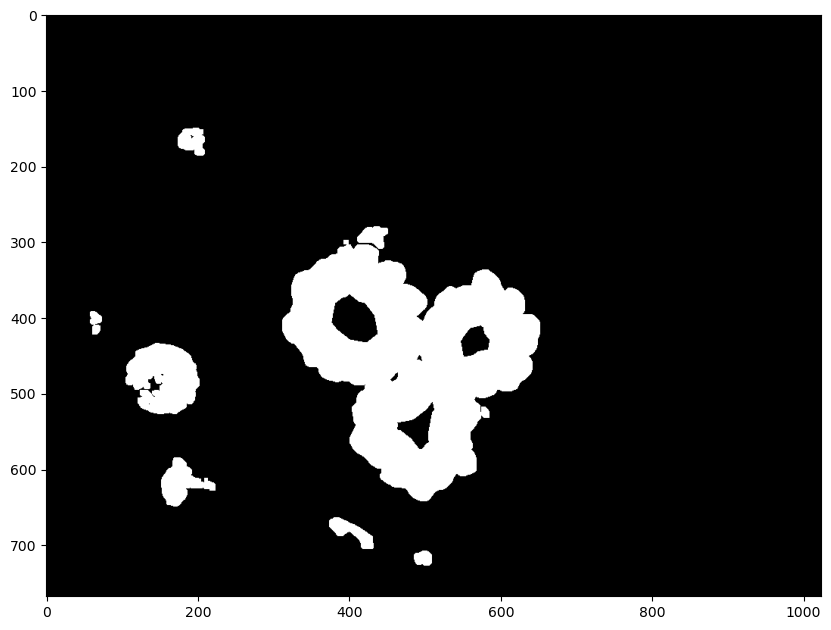

In [317]:
display(unknown,cmap='gray')

In [318]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

In [319]:
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

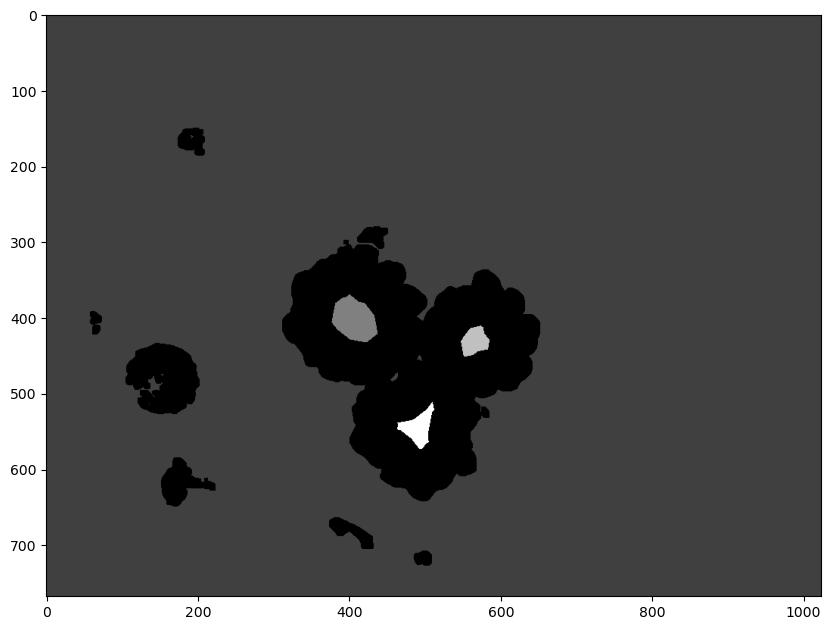

In [320]:
display(markers,cmap='gray')

In [321]:
markers = cv2.watershed(img,markers)

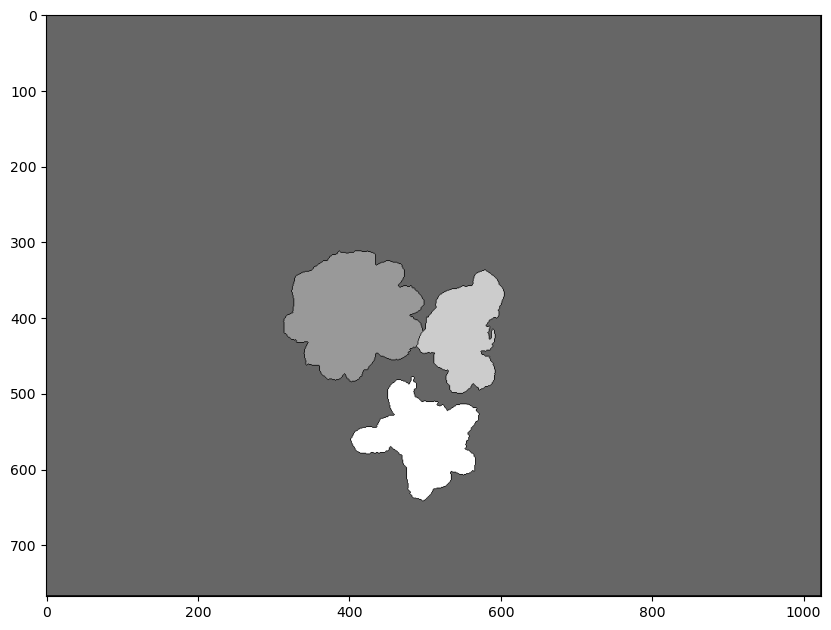

In [322]:
display(markers,cmap='gray')

In [323]:
image, contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# # For every entry in contours
# for i in range(len(contours)):
    
#     # last column in the array is -1 if an external contour (no contours inside of it)
#     if hierarchy[0][i][3] == -1:
        
#         # We can now draw the external contours from the list of contours
#         cv2.drawContours(img, contours, i, (255, 0, 0), 10)

In [324]:
hierarchy

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 4,  2, -1, -1],
        [ 5,  3, -1, -1],
        [-1,  4, -1, -1]]], dtype=int32)

In [325]:
#display(img,cmap='gray')

In [326]:
for i in range(len(contours)):
    #M = cv2.moments(i)
    #cx = int(M['m10']/M['m00'])
    #cy = int(M['m01']/M['m00'])
    if hierarchy[0][i][3] == -1:
        x,y,w,h = cv2.boundingRect(contours[i])
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

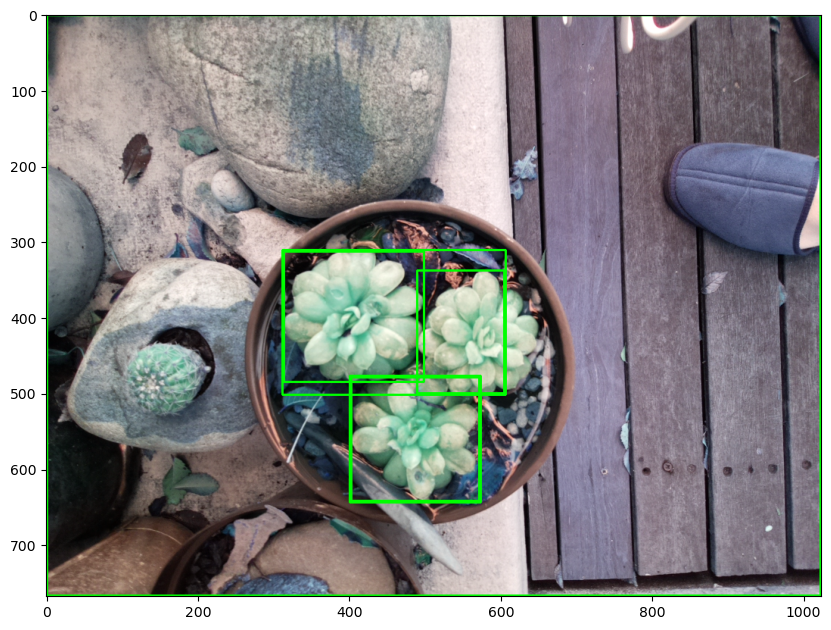

In [327]:
display(img)
